In [1]:
import pandas as pd
from google.cloud import aiplatform as vertexai
from pandas_gbq import to_gbq
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

In [2]:
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]

BQ_LOCATION = 'US'
REGION = 'us-central1'

In [3]:
GCS_BUCKET = f"khue-capstone-bucket"
BQ_DATASET = f"{PROJECT_ID}:khue_capstone"

In [4]:
vertexai.init(project=PROJECT_ID, location=REGION, staging_bucket=f"gs://{GCS_BUCKET}")

In [ ]:
# get counts of target labels
%%bigquery label_counts --project $PROJECT_ID 
SELECT add_to_cart, COUNT(*) AS total 
FROM khue_capstone.hits_data
GROUP BY add_to_cart

# Models

### Boosted Tree

In [161]:
%%bigquery --project $PROJECT_ID
CREATE OR REPLACE MODEL khue_capstone.khue_boosted_tree_model
OPTIONS(
  MODEL_TYPE="BOOSTED_TREE_CLASSIFIER",
  INPUT_LABEL_COLS=["add_to_cart"],
  DATA_SPLIT_METHOD="AUTO_SPLIT",
  ENABLE_GLOBAL_EXPLAIN=True,
  HPARAM_TUNING_ALGORITHM="RANDOM_SEARCH", 
  num_trials=4,
  max_parallel_trials=3,
  HPARAM_TUNING_OBJECTIVES=["ROC_AUC"],
  EARLY_STOP=True
) AS
SELECT
  * 
FROM
  khue_capstone.hits_data

Query is running:   0%|          |

""


### Logistic Regression

In [8]:
%%bigquery --project $PROJECT_ID
CREATE OR REPLACE MODEL khue_capstone.khue_logistic_model
OPTIONS(
    MODEL_TYPE="LOGISTIC_REG",
    INPUT_LABEL_COLS=["add_to_cart"],
    DATA_SPLIT_METHOD="AUTO_SPLIT",
    AUTO_CLASS_WEIGHTS=True,
    ENABLE_GLOBAL_EXPLAIN=True,
    HPARAM_TUNING_ALGORITHM="RANDOM_SEARCH", 
    num_trials=4,
    max_parallel_trials=3,
    HPARAM_TUNING_OBJECTIVES=["ROC_AUC"],
    EARLY_STOP=True
) AS
SELECT * FROM khue_capstone.hits_data

Query is running:   0%|          |

""


### Deep Neural Networks

In [10]:
%%bigquery --project $PROJECT_ID
CREATE OR REPLACE MODEL khue_capstone.khue_DNN_model
OPTIONS(
    MODEL_TYPE="DNN_CLASSIFIER",
    INPUT_LABEL_COLS=["add_to_cart"],
    DATA_SPLIT_METHOD="AUTO_SPLIT",
    AUTO_CLASS_WEIGHTS=True,
    HPARAM_TUNING_ALGORITHM="RANDOM_SEARCH", 
    num_trials=4,
    max_parallel_trials=3,
    HPARAM_TUNING_OBJECTIVES=["ROC_AUC"],
    EARLY_STOP=True
) AS
SELECT * FROM khue_capstone.hits_data

Query is running:   0%|          |

""


### Wide and Deep Network

In [15]:
%%bigquery --project $PROJECT_ID
CREATE OR REPLACE MODEL khue_capstone.khue_deep_network_model
OPTIONS(
    MODEL_TYPE="DNN_LINEAR_COMBINED_CLASSIFIER",
    INPUT_LABEL_COLS=["add_to_cart"],
    DATA_SPLIT_METHOD="AUTO_SPLIT",
    AUTO_CLASS_WEIGHTS=True,
    HPARAM_TUNING_ALGORITHM="RANDOM_SEARCH", 
    num_trials=4,
    max_parallel_trials=3,
    HPARAM_TUNING_OBJECTIVES=["ROC_AUC"],
    EARLY_STOP=True,
    OPTIMIZER="SGD"
) AS
SELECT * FROM khue_capstone.hits_data

### Logistice Regression with Undersampling

In [25]:
%%bigquery --project $PROJECT_ID
CREATE OR REPLACE MODEL khue_capstone.khue_logistic_undersample_model
OPTIONS(
    MODEL_TYPE="LOGISTIC_REG",
    INPUT_LABEL_COLS=["add_to_cart"],
    DATA_SPLIT_METHOD="AUTO_SPLIT",
    AUTO_CLASS_WEIGHTS=True,
    ENABLE_GLOBAL_EXPLAIN=True,
    HPARAM_TUNING_ALGORITHM="RANDOM_SEARCH", 
    num_trials=4,
    max_parallel_trials=3,
    HPARAM_TUNING_OBJECTIVES=["ROC_AUC"],
    EARLY_STOP=True
) AS
WITH balanced_data AS (
  SELECT * FROM (
    SELECT * FROM khue_capstone.hits_data WHERE add_to_cart = 0 
    ORDER BY RAND()  -- Randomize the order
    LIMIT (8082)  -- Limit to the number of minority class examples
  ) 
  UNION ALL
  SELECT * FROM khue_capstone.hits_data WHERE add_to_cart = 1 
)
SELECT * FROM balanced_data


Executing query with job ID: 5e131832-8dff-4bf9-acac-3863d1aa06bf
Query executing: 0.45s


ERROR:
 400 LIMIT expects an integer literal or parameter at [18:11]; reason: invalidQuery, location: query, message: LIMIT expects an integer literal or parameter at [18:11]

Location: US
Job ID: 5e131832-8dff-4bf9-acac-3863d1aa06bf



### Logistice Regression with Oversampling

In [ ]:
%%bigquery --project $PROJECT_ID
CREATE OR REPLACE MODEL khue_capstone.khue_logistic_oversample_model
OPTIONS(
  MODEL_TYPE="LOGISTIC_REG",
  INPUT_LABEL_COLS=["add_to_cart"],
  DATA_SPLIT_METHOD="AUTO_SPLIT",
  AUTO_CLASS_WEIGHTS=True,
  ENABLE_GLOBAL_EXPLAIN=True,
  HPARAM_TUNING_ALGORITHM="RANDOM_SEARCH", 
  num_trials=4,
  max_parallel_trials=3,
  HPARAM_TUNING_OBJECTIVES=["ROC_AUC"],
  EARLY_STOP=True
)
AS

WITH balanced_data AS (
  SELECT * FROM (
    SELECT * FROM khue_capstone.hits_data WHERE add_to_cart = 0 
    UNION ALL
    SELECT * FROM khue_capstone.hits_data WHERE add_to_cart = 1  
  ) 
  CROSS JOIN UNNEST(GENERATE_ARRAY(1, 100)) as _  
)

SELECT * FROM balanced_data;

### Logistic Regression (Weights Modified)

In [79]:
%%bigquery --project $PROJECT_ID
CREATE OR REPLACE MODEL khue_capstone.khue_logistic_weighted_model
OPTIONS(
    MODEL_TYPE="LOGISTIC_REG",
    INPUT_LABEL_COLS=["add_to_cart"],
    DATA_SPLIT_METHOD="AUTO_SPLIT",
    CLASS_WEIGHTS=[
        STRUCT('0', 1.0), 
        STRUCT('1', 125.0)
    ],
    ENABLE_GLOBAL_EXPLAIN=True,
    HPARAM_TUNING_ALGORITHM="RANDOM_SEARCH", 
    num_trials=4,
    max_parallel_trials=3,
    HPARAM_TUNING_OBJECTIVES=["ROC_AUC"],
    EARLY_STOP=True
) AS
SELECT * FROM khue_capstone.hits_data

Query is running:   0%|          |

""


# Models Metrics

### Boosted Tree

In [162]:
%%bigquery boosted_tree_model_df --project $PROJECT_ID 
SELECT * FROM ML.EVALUATE(MODEL khue_capstone.khue_boosted_tree_model) 

Query is running:   0%|          |

Downloading:   0%|          |

In [163]:
display(boosted_tree_model_df)

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1,0.946860,0.235012,0.994287,0.376561,0.031917,0.862691
1,2,0.951456,0.235012,0.994296,0.376923,0.126629,0.873452
2,3,0.946860,0.235012,0.994287,0.376561,0.315715,0.869742
3,4,0.968468,0.257794,0.994490,0.407197,0.024491,0.921780


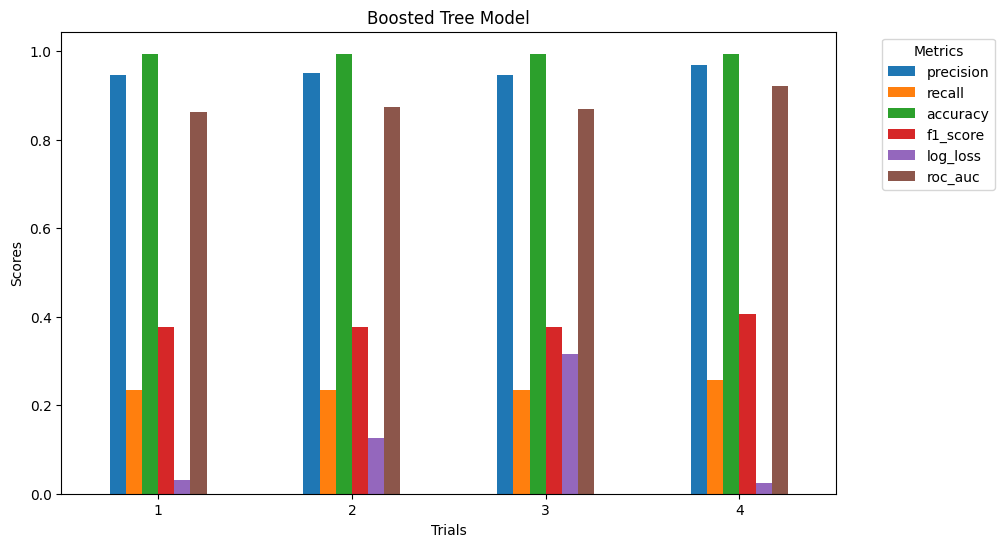

In [170]:
ax = boosted_tree_model_df.plot(x='trial_id', kind='bar', figsize=(10, 6))
plt.xlabel('Trials')
plt.ylabel('Scores')
plt.title('Boosted Tree Model')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

### Logistic Regression

In [67]:
%%bigquery logistic_model_df --project $PROJECT_ID 
SELECT * FROM ML.EVALUATE(MODEL khue_capstone.khue_logistic_model)

Query is running:   0%|          |

Downloading:   0%|          |

In [68]:
display(logistic_model_df)

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1,0.042839,0.741007,0.876559,0.080996,0.344451,0.896081
1,2,0.042839,0.741007,0.876559,0.080996,0.344451,0.896081
2,3,0.042839,0.741007,0.876559,0.080996,0.344451,0.896081
3,4,0.042839,0.741007,0.876559,0.080996,0.344451,0.896081


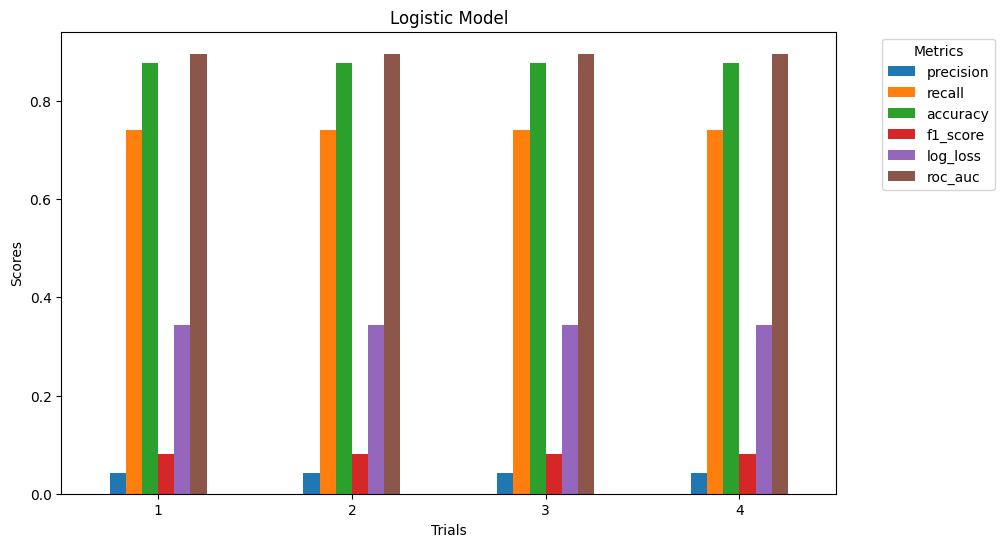

In [60]:
ax = logistic_model_df.plot(x='trial_id', kind='bar', figsize=(10, 6))
plt.xlabel('Trials')
plt.ylabel('Scores')
plt.title('Logistic Model')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

### Deep Neural Networks

In [69]:
%%bigquery DNN_model_df --project $PROJECT_ID 
SELECT * FROM ML.EVALUATE(MODEL khue_capstone.khue_DNN_model)

Query is running:   0%|          |

Downloading:   0%|          |

In [70]:
display(DNN_model_df)

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1,0.057965,0.890887,0.892913,0.108849,0.255923,0.958231
1,2,0.059085,0.860911,0.898336,0.110581,0.275339,0.950781
2,3,0.045237,0.859712,0.865768,0.085951,0.317954,0.940151
3,4,0.075748,0.886091,0.919795,0.139566,0.226110,0.960855


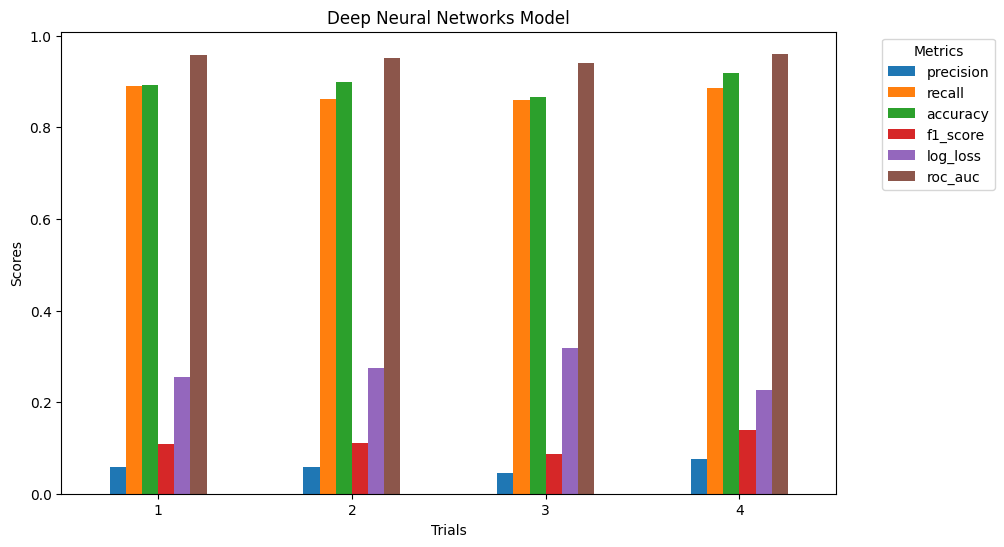

In [63]:
ax = DNN_model_df.plot(x='trial_id', kind='bar', figsize=(10, 6))
plt.xlabel('Trials')
plt.ylabel('Scores')
plt.title('Deep Neural Networks Model')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

### Wide And Deep Classifier

In [71]:
%%bigquery deep_network_model_df --project $PROJECT_ID 
SELECT * FROM ML.EVALUATE(MODEL khue_capstone.khue_deep_network_model)

Query is running:   0%|          |

Downloading:   0%|          |

In [72]:
display(deep_network_model_df)

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1,0.038730,0.836930,0.846315,0.074035,0.340094,0.921901
1,2,0.023374,0.733813,0.772967,0.045305,0.518926,0.839515
2,3,0.042728,0.852518,0.858708,0.081378,0.319406,0.932408
3,4,0.042455,0.847722,0.858524,0.080860,0.318603,0.933915


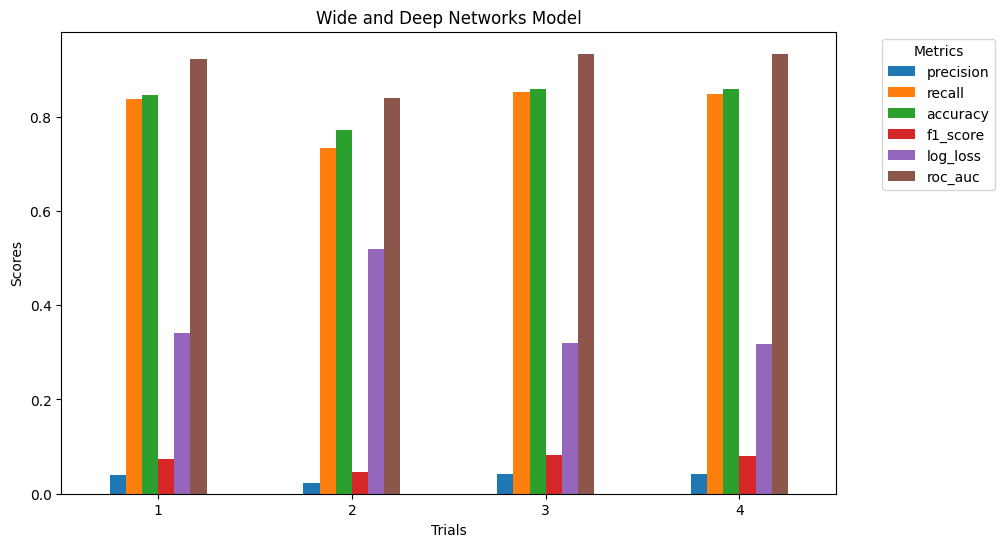

In [70]:
ax = deep_network_model_df.plot(x='trial_id', kind='bar', figsize=(10, 6))
plt.xlabel('Trials')
plt.ylabel('Scores')
plt.title('Wide and Deep Networks Model')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

### Logistic Undersampling

In [21]:
%%bigquery logistic_undersample_model_df --project $PROJECT_ID 
SELECT * FROM ML.EVALUATE(MODEL khue_capstone.khue_logistic_undersample_model)

Query is running:   0%|          |

Downloading:   0%|          |

In [22]:
display(logistic_undersample_model_df)

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1,0.845088,0.804556,0.829050,0.824324,0.396735,0.905489
1,2,0.844221,0.805755,0.829050,0.824540,0.397333,0.905156
2,3,0.845088,0.804556,0.829050,0.824324,0.396637,0.905724
3,4,0.840000,0.805755,0.826659,0.822521,0.397961,0.904774


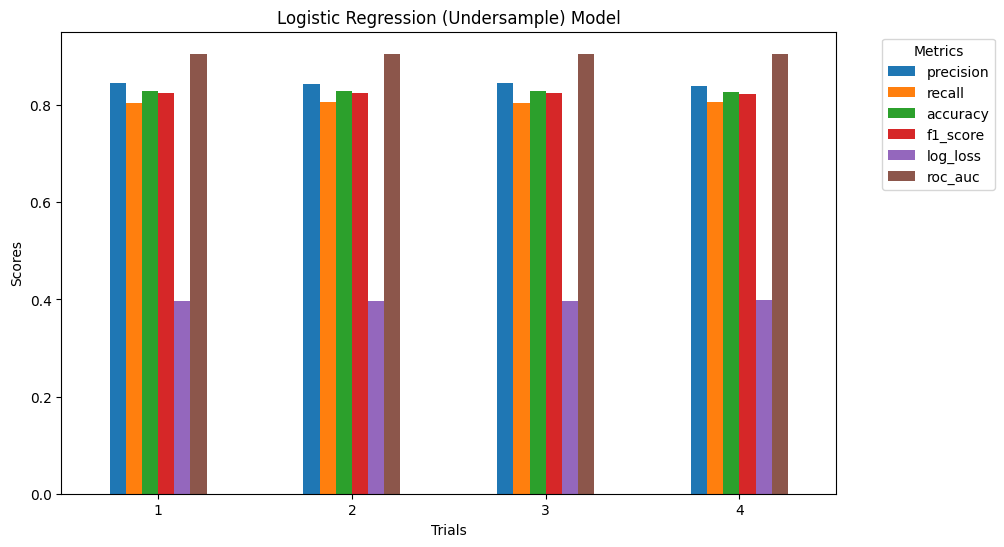

In [65]:
ax = logistic_undersample_model_df.plot(x='trial_id', kind='bar', figsize=(10, 6))
plt.xlabel('Trials')
plt.ylabel('Scores')
plt.title('Logistic Regression (Undersample) Model')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

### Logistic Oversampling

In [73]:
%%bigquery logistic_oversample_model_df --project $PROJECT_ID 
SELECT * FROM ML.EVALUATE(MODEL khue_capstone.khue_logistic_oversample_model)

Query is running:   0%|          |

Downloading:   0%|          |

In [74]:
display(logistic_oversample_model_df)

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1,0.041672,0.747326,0.876669,0.078942,0.342928,0.907319
1,2,0.041672,0.747326,0.876669,0.078942,0.342928,0.907327
2,3,0.041672,0.747326,0.876669,0.078942,0.342928,0.907323
3,4,0.041672,0.747326,0.876669,0.078942,0.342928,0.907304


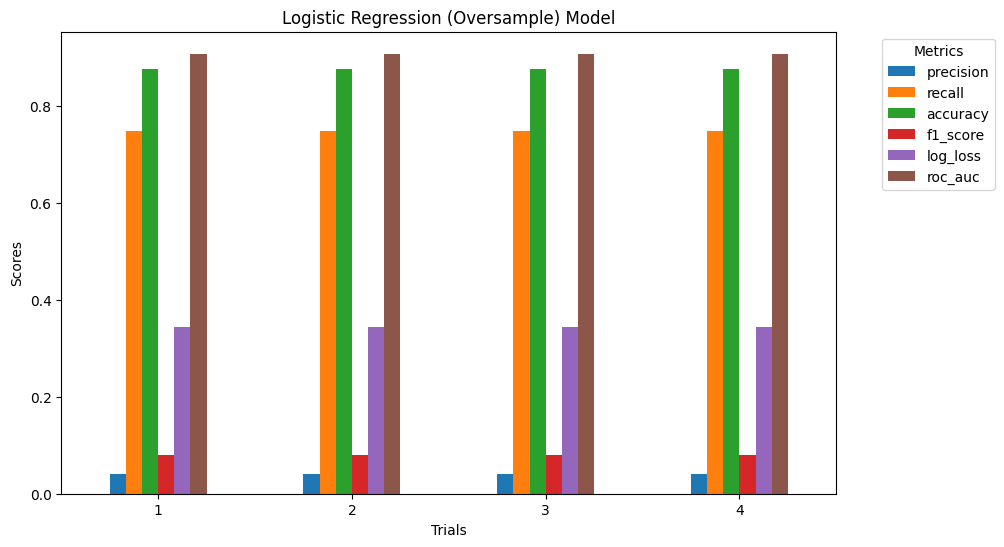

In [66]:
ax = logistic_oversample_model_df.plot(x='trial_id', kind='bar', figsize=(10, 6))
plt.xlabel('Trials')
plt.ylabel('Scores')
plt.title('Logistic Regression (Oversample) Model')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

### Logistic Regression (Weighted) Model

In [59]:
%%bigquery logistic_weighted_model_df --project $PROJECT_ID 
SELECT * FROM ML.EVALUATE(MODEL khue_capstone.khue_logistic_weighted_model) 

Query is running:   0%|          |

Downloading:   0%|          |

In [75]:
display(logistic_weighted_model_df)

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1,0.039605,0.720624,0.869667,0.075083,0.383574,0.886491
1,2,0.039605,0.720624,0.869667,0.075083,0.383580,0.886489
2,3,0.039602,0.720624,0.869658,0.075078,0.383633,0.886493
3,4,0.041442,0.711031,0.877149,0.078320,0.369842,0.887264


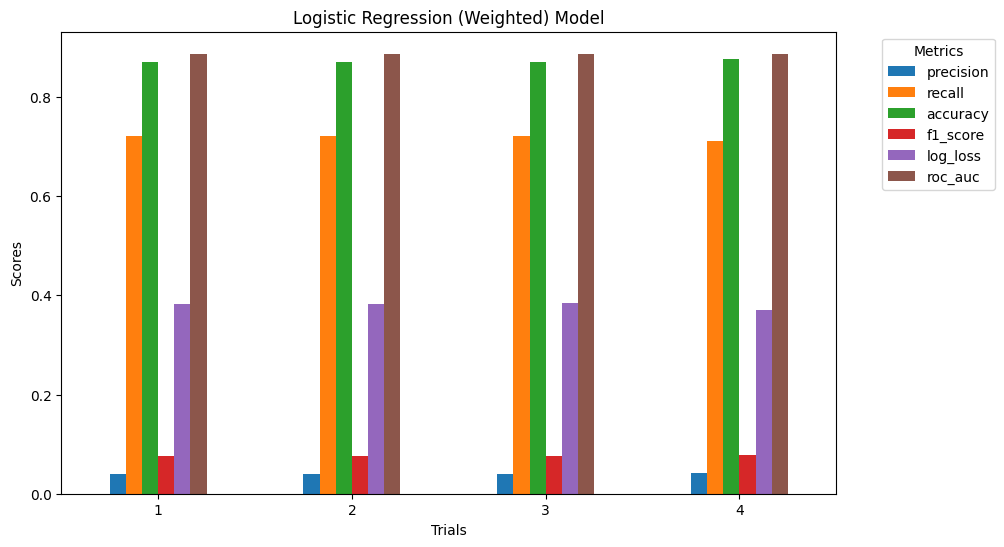

In [60]:
ax = logistic_weighted_model_df.plot(x='trial_id', kind='bar', figsize=(10, 6))
plt.xlabel('Trials')
plt.ylabel('Scores')
plt.title('Logistic Regression (Weighted) Model')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

# Validation

### Validate Logistic (undersampling) Model

In [40]:
%%bigquery logistic_undersample_model_validate_df --project $PROJECT_ID 
SELECT *
FROM ML.EVALUATE(MODEL khue_capstone.khue_logistic_undersample_model, (
  SELECT * FROM khue_capstone.may_2017
))

Query is running:   0%|          |

Downloading:   0%|          |

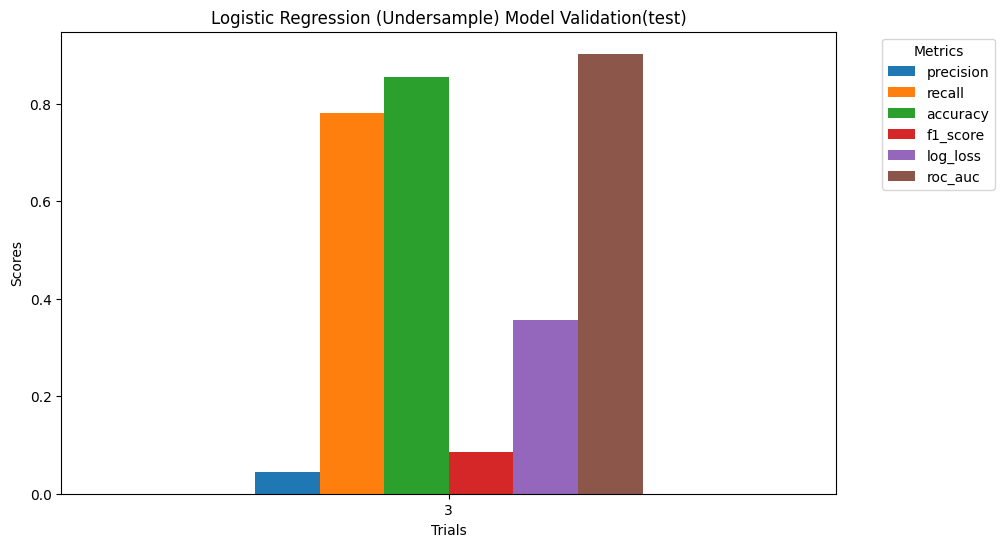

In [166]:
ax = logistic_undersample_model_validate_df.plot(x='trial_id', kind='bar', figsize=(10, 6))
plt.xlabel('Trials')
plt.ylabel('Scores')
plt.title('Logistic Regression (Undersample) Model Validation(test)')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

In [93]:
display(logistic_undersample_model_validate_df)

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,3,0.045435,0.780772,0.854238,0.085872,0.355758,0.902628


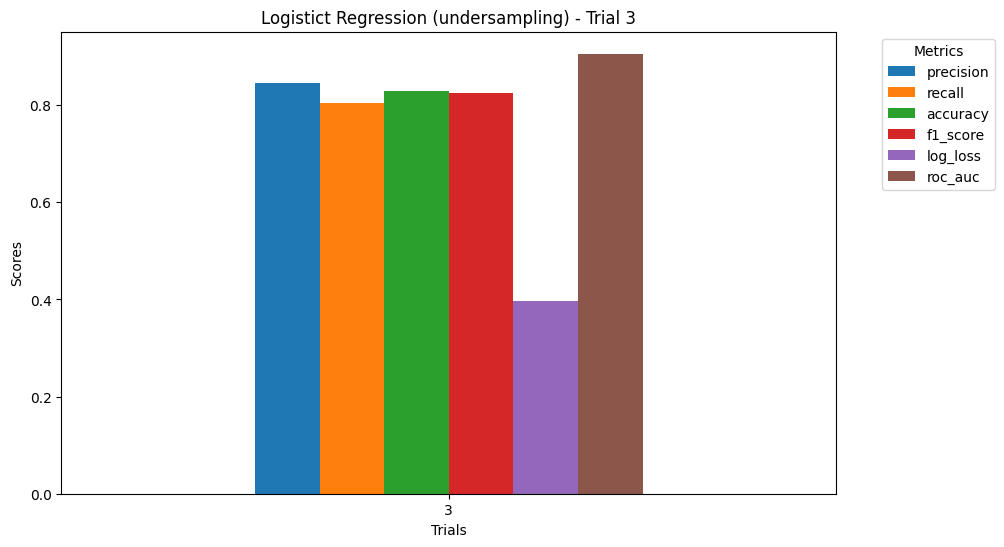

In [95]:
row_to_plot = logistic_undersample_model_df[logistic_undersample_model_df['trial_id'] == 3]

# Plot the selected row
ax = row_to_plot.plot(x='trial_id', kind='bar', figsize=(10, 6))
plt.xlabel('Trials')
plt.ylabel('Scores')
plt.title('Logistict Regression (undersampling) - Trial 3')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

In [96]:
display(row_to_plot)

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
2,3,0.845088,0.804556,0.82905,0.824324,0.396637,0.905724


### Validate Boosted Tree Model

In [246]:
%%bigquery boosted_tree_validate_df --project $PROJECT_ID 
SELECT *
FROM ML.EVALUATE(MODEL khue_capstone.khue_boosted_tree_model, (
  SELECT * FROM khue_capstone.may_2017
))

Query is running:   0%|          |

Downloading:   0%|          |

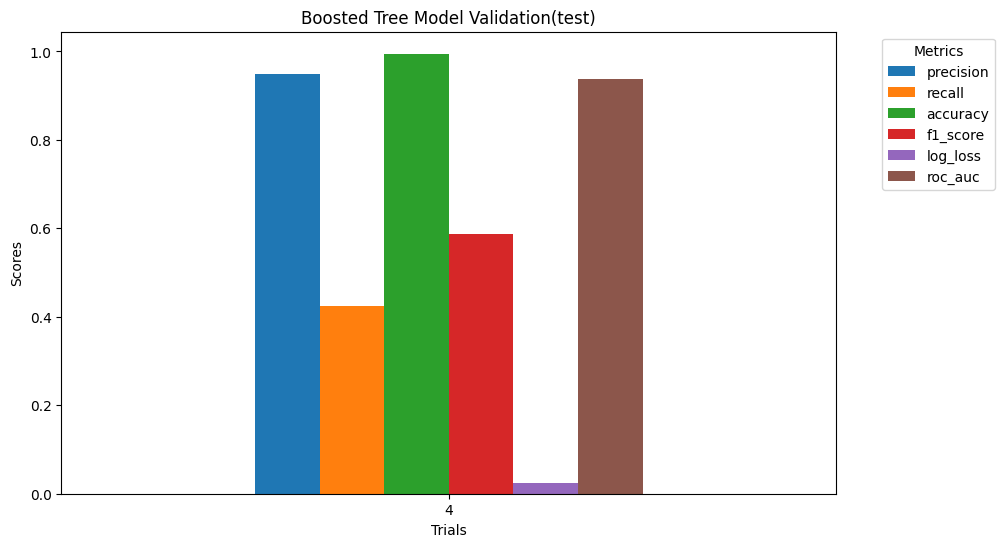

In [247]:
ax = boosted_tree_validate_df.plot(x='trial_id', kind='bar', figsize=(10, 6))
plt.xlabel('Trials')
plt.ylabel('Scores')
plt.title('Boosted Tree Model Validation(test)')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

In [248]:
display(boosted_tree_validate_df)

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,4,0.949657,0.423982,0.994752,0.586235,0.024162,0.937067


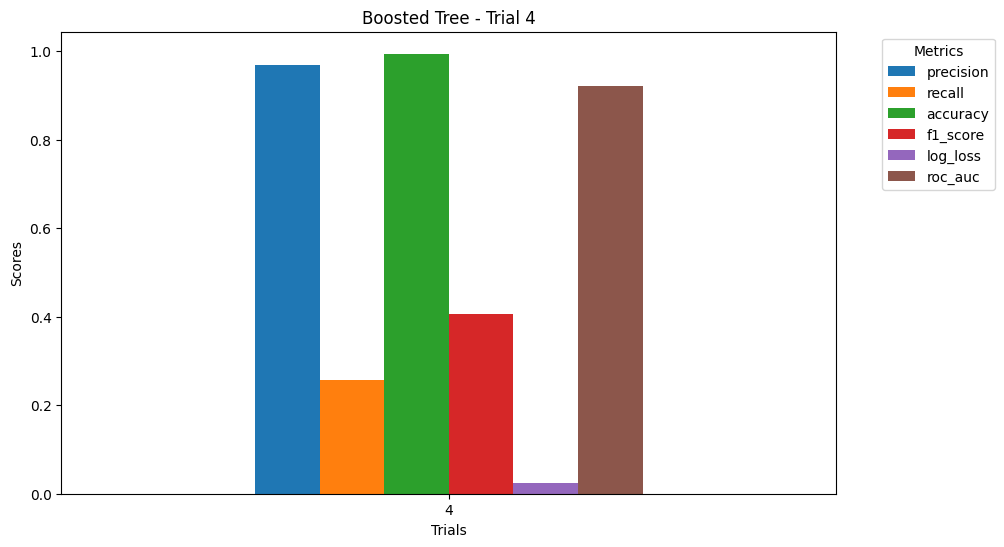

In [250]:
row_to_plot = boosted_tree_model_df[boosted_tree_model_df['trial_id'] == 4]

# Plot the selected row
ax = row_to_plot.plot(x='trial_id', kind='bar', figsize=(10, 6))
plt.xlabel('Trials')
plt.ylabel('Scores')
plt.title('Boosted Tree - Trial 4')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

In [251]:
display(row_to_plot)

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
3,4,0.968468,0.257794,0.99449,0.407197,0.024491,0.92178


# Upload and Deploy Model

In [5]:
# set model name
MODEL_NAME = 'khue_boosted_tree_model'

In [6]:
# set dataset model name
BQ_MODEL = f"{BQ_DATASET}.{MODEL_NAME}"
BQ_MODEL_EXPORT_DIR = f"gs://{GCS_BUCKET}/{MODEL_NAME}"

In [7]:
# path to bucket
!bq --location=$BQ_LOCATION extract \
--destination_format ML_XGBOOST_BOOSTER \
--model $BQ_MODEL \
$BQ_MODEL_EXPORT_DIR

Waiting on bqjob_r17a3e0681a017f89_0000018dd649b1d0_1 ... (3s) Current status: DONE   


In [8]:
# image
IMAGE_URI='us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-4:latest'

In [9]:
# upload model to bucket
model = vertexai.Model.upload(
    display_name=MODEL_NAME,
    artifact_uri=BQ_MODEL_EXPORT_DIR,
    serving_container_image_uri=IMAGE_URI,
)

Creating Model
Create Model backing LRO: projects/319407066227/locations/us-central1/models/7800161986838265856/operations/7540345224531279872
Model created. Resource name: projects/319407066227/locations/us-central1/models/7800161986838265856@1
To use this Model in another session:
model = aiplatform.Model('projects/319407066227/locations/us-central1/models/7800161986838265856@1')


In [24]:
# deploy model to endpoint
endpoint = model.deploy(
    traffic_split={"0": 100},
    machine_type="e2-standard-2",
)

Creating Endpoint
Create Endpoint backing LRO: projects/319407066227/locations/us-central1/endpoints/6713417888084000768/operations/1279215842579447808
Endpoint created. Resource name: projects/319407066227/locations/us-central1/endpoints/6713417888084000768
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/319407066227/locations/us-central1/endpoints/6713417888084000768')
Deploying model to Endpoint : projects/319407066227/locations/us-central1/endpoints/6713417888084000768
Deploy Endpoint model backing LRO: projects/319407066227/locations/us-central1/endpoints/6713417888084000768/operations/3216889582255603712
Endpoint model deployed. Resource name: projects/319407066227/locations/us-central1/endpoints/6713417888084000768


# Model Online Predictions

In [25]:
CATEGORICAL_FEATURES = ['country', 'device', 'product_category', 'product_name', 'sub_continent',]

In [26]:
def _build_cat_feature_encoders(cat_feature_list, gcs_bucket, model_name, na_value='Unknown'):
 
    feature_encoders = {}
    
    for idx, feature in enumerate(cat_feature_list):
        feature_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        feature_vocab_file = f"gs://{gcs_bucket}/{model_name}/assets/{idx}_categorical_label.txt"
        feature_vocab_df = pd.read_csv(feature_vocab_file, delimiter = "\t", header=None).fillna(na_value)
        feature_encoder.fit(feature_vocab_df.values)
        feature_encoders[feature] = feature_encoder
    
    return feature_encoders

In [27]:
def preprocess_xgboost(instances, cat_feature_list, feature_encoders):
  
    transformed_instances = []
    
    for instance in instances:
        for feature in cat_feature_list:
            feature_int = feature_encoders[feature].transform([[instance[feature]]]).item()
            instance[feature] = feature_int
            instance_list = list(instance.values())
        transformed_instances.append(instance_list)

    return transformed_instances

In [28]:
feature_encoders = _build_cat_feature_encoders(CATEGORICAL_FEATURES, GCS_BUCKET, MODEL_NAME)

In [29]:
%%bigquery aug_df --project $PROJECT_ID 
SELECT *
FROM khue_capstone.Aug_1_2017

Query is running:   0%|          |

Downloading:   0%|          |

In [30]:
filtered_df = aug_df[aug_df['add_to_cart'] == 1]

In [31]:
test_df = aug_df.loc[[0,1,2,35516,35550,35621]]
test_df = test_df.drop(['add_to_cart'], axis=1)

In [32]:
display(test_df)
print(test_df.shape)

,day,month,year,hits,page_views,time_on_site,hour,minute,device,sub_continent,country,product_category,product_name,product_price
0,1,8,2017,18,15,493,8,32,tablet,Western Asia,Iraq,Home/Shop by Brand/YouTube,YouTube Custom Decals,1.99
1,1,8,2017,18,15,493,8,32,tablet,Western Asia,Iraq,Home/Shop by Brand/YouTube,22 oz YouTube Bottle Infuser,4.99
2,1,8,2017,18,15,493,8,32,tablet,Western Asia,Iraq,Home/Shop by Brand/YouTube,YouTube Twill Cap,10.99
35516,1,8,2017,17,13,504,15,42,desktop,Caribbean,Dominican Republic,Home/Shop by Brand/YouTube,YouTube Men's Short Sleeve Hero Tee Black,16.99
35550,1,8,2017,36,27,832,7,47,desktop,Caribbean,Dominican Republic,${escCatTitle},YouTube Custom Decals,1.99
35621,1,8,2017,36,27,832,7,54,desktop,Caribbean,Dominican Republic,${escCatTitle},Google Laptop and Cell Phone Stickers,2.99


(6, 14)


In [33]:
feature_encoders = _build_cat_feature_encoders(CATEGORICAL_FEATURES, GCS_BUCKET, MODEL_NAME)

In [34]:
test_instances = test_df.astype(str).to_dict(orient='records')

In [35]:
transformed_test_instances = preprocess_xgboost(test_instances, CATEGORICAL_FEATURES, feature_encoders)

In [48]:
print(transformed_test_instances)

[['1', '8', '2017', '18', '15', '493', '8', '32', 3.0, 20.0, 68.0, 52.0, 346.0, '1.99'], ['1', '8', '2017', '18', '15', '493', '8', '32', 3.0, 20.0, 68.0, 52.0, 4.0, '4.99'], ['1', '8', '2017', '18', '15', '493', '8', '32', 3.0, 20.0, 68.0, 52.0, 367.0, '10.99'], ['1', '8', '2017', '17', '13', '504', '15', '42', 1.0, 2.0, 39.0, 52.0, 355.0, '16.99'], ['1', '8', '2017', '36', '27', '832', '7', '47', 1.0, 2.0, 39.0, 0.0, 346.0, '1.99'], ['1', '8', '2017', '36', '27', '832', '7', '54', 1.0, 2.0, 39.0, 0.0, 138.0, '2.99']]


In [51]:
predictions = endpoint.predict(instances=transformed_test_instances)

In [52]:
for idx, prediction in enumerate(predictions.predictions):
    # Class labels [1,0] retrieved from model_metadata.json in GCS model dir.
    # BQML binary classification default is 0.5 with above "Churn" and below "Not Churn".
    is_churned = "Add to Cart" if prediction[0] >= 0.5 else "Did not Add to Cart"
    print(f"Prediction: Customer {idx} - {is_churned} {prediction}")
    # print(test_df.iloc[idx].astype(str).to_json() + "\n")

Prediction: Customer 0 - Did not Add to Cart [0.007056023459881544, 0.9929439425468445]
Prediction: Customer 1 - Did not Add to Cart [0.005723333917558193, 0.9942767024040222]
Prediction: Customer 2 - Did not Add to Cart [0.006475087255239487, 0.9935249090194702]
Prediction: Customer 3 - Did not Add to Cart [0.000867702707182616, 0.9991323351860046]
Prediction: Customer 4 - Add to Cart [0.9250322580337524, 0.07496768981218338]
Prediction: Customer 5 - Add to Cart [0.9253712892532349, 0.07462877035140991]
